# Transfer learning on the flower dataset
Potential improve

In [1]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### fetch the data

In [2]:
import sys
import tarfile
from six.moves import urllib
import os

In [3]:
FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

### we need to fetch data when necessary

In [4]:
fetch_flowers()

### Each subdirectory of the flower_photos directory contains all the pictures of a given class. Let's get the list of classes

In [5]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Let's get the list of all the image file paths for each class

In [6]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

#### Let's sort the image paths just to make this notebook behave consistently across multiple runs

In [7]:
for paths in image_paths.values():
    paths.sort()  

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### image preprocessing
Try to use **inception_preprocessing.py** here.

In [9]:
from inception_preprocessing import preprocess_image

In [10]:
test_image = mpimg.imread("datasets/flowers/flower_photos/daisy/488202750_c420cbce61.jpg")

In [11]:
test_image.shape

(375, 500, 3)

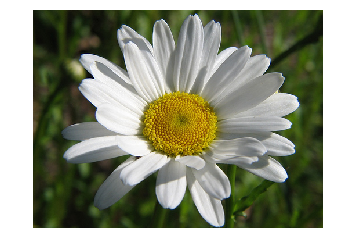

In [12]:
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [13]:
import tensorflow as tf
import numpy as np

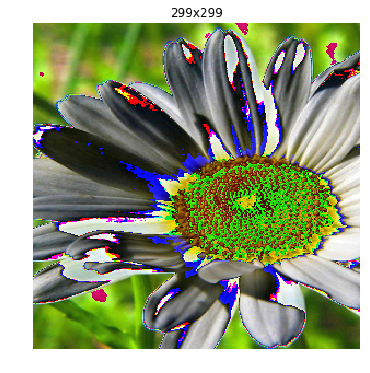

In [14]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = preprocess_image(input_image, 299, 299, is_training=True)

with tf.Session():
    prepared_image = prepared_image_op.eval(feed_dict={input_image: test_image})
    
plt.figure(figsize=(6, 6))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

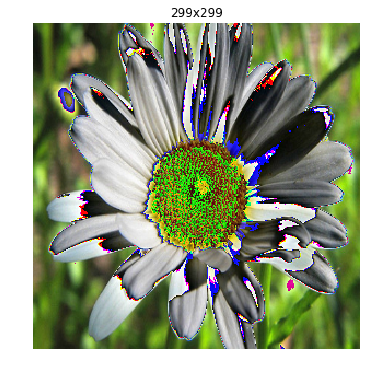

In [15]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = preprocess_image(input_image, 299, 299, is_training=False)

with tf.Session():
    prepared_image = prepared_image_op.eval(feed_dict={input_image: test_image})
    
plt.figure(figsize=(6, 6))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

### check in batch to see the effect of data augmentation

In [16]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = preprocess_image(input_image, 299, 299, is_training=True)

prepared_images = []
with tf.Session():
    for i in range(6):
        prepared_images.append(prepared_image_op.eval(feed_dict={input_image: test_image}))

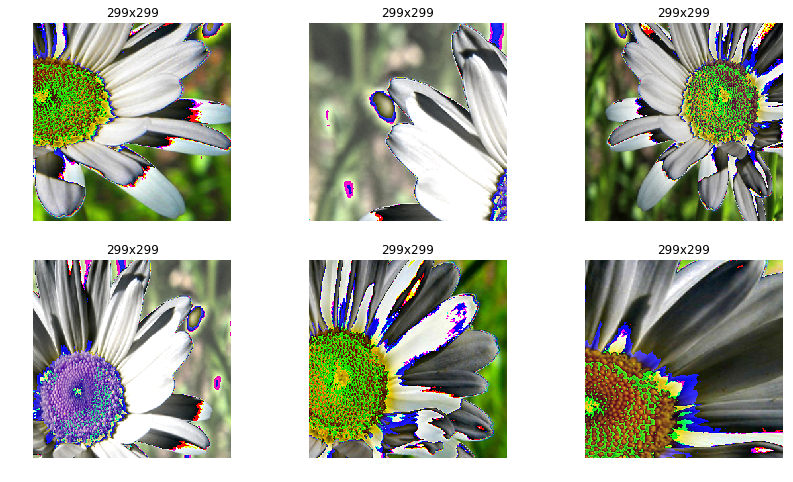

In [17]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepared_images[row*3+col]
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

## Use the pretrained Inception V3 model
Using the pretrained Inception v3 model from the previous exercise, freeze all layers up to the bottleneck layer (i.e., the last layer before the output layer), and replace the output layer with the appropriate number of outputs for your new classification task (e.g., the flowers dataset has five mutually exclusive classes so the output layer must have five neurons and use the softmax activation function).

### prepare data

In [18]:
# encode the flower class
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [19]:
# prepare training and test dataset
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

In [20]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

### construct the graph

In [21]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

In [22]:
reset_graph()

width = 299
height = 299
channels = 3

initial_learning_rate = 0.0002
learning_rate_decay_factor = 0.7
num_epochs_before_decay = 2

batch_size = 32
global_step = tf.train.get_or_create_global_step()
num_steps_per_epoch = len(flower_paths_and_classes_train) // batch_size
decay_steps = int(num_epochs_before_decay * num_steps_per_epoch)

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
y = tf.placeholder(tf.int32, shape=[None])
training = tf.placeholder_with_default(False, shape=[])

# for image preprocessing
input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op_train = preprocess_image(input_image, 299, 299, is_training=True)
prepared_image_op_test = preprocess_image(input_image, 299, 299, is_training=False)

with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

In [23]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    # new output layer
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    
    # learning rate decay here
    lr = tf.train.exponential_decay(
        learning_rate = initial_learning_rate, 
        global_step = global_step, 
        decay_steps = decay_steps, 
        decay_rate = learning_rate_decay_factor, 
        staircase=True)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    #optimizer = tf.train.AdamOptimizer()
    
    # we need to point out which parameters are allowed to update
    #flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = slim.learning.create_train_op(loss, optimizer)
    #training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [24]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('losses', loss)
accuracy_summary = tf.summary.scalar('accuracy', accuracy)
lr_summary = tf.summary.scalar('learning_rate', lr)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

### run the graph

In [25]:
from __future__ import division, print_function, unicode_literals

In [26]:
from random import sample

def get_batch(flower_paths_and_classes, iteration, batch_size):
    if iteration == 0:
        np.random.shuffle(flower_paths_and_classes)
    batch_paths_and_classes = flower_paths_and_classes[iteration * batch_size : (iteration + 1) * batch_size]
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    X_batch = images
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [27]:
%%time
n_epochs = 70

INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(num_steps_per_epoch):
            X_batch_raw, y_batch = get_batch(flower_paths_and_classes_train, iteration, batch_size)
            # image preprocessing
            X_batch = np.stack([prepared_image_op_train.eval(feed_dict={input_image: batch_image}) for batch_image in X_batch_raw])
            batch_loss, batch_acc, global_step_count, learning_rate_now = sess.run([training_op, accuracy, global_step, lr], 
                                                                        feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % 5 == 0:
                loss_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch, training: True})
                accuracy_str = accuracy_summary.eval(feed_dict={X: X_batch, y: y_batch, training: True})
                lr_str = lr_summary.eval()
                
                step = epoch * num_steps_per_epoch + iteration
                file_writer.add_summary(loss_str, step)
                file_writer.add_summary(accuracy_str, step)
                file_writer.add_summary(lr_str, step)
                print(".", end="")

        #acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", batch_acc, " Loss:", batch_loss, 
              " Global step:", global_step_count, " lr:", learning_rate_now)

        save_path = saver.save(sess, "./my_flowers_model")
file_writer.close()

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0...................  Train accuracy: 0.75  Loss: 0.645152  Global step: 91  lr: 0.0002
Epoch 1...................  Train accuracy: 0.9375  Loss: 0.192446  Global step: 182  lr: 0.0002
Epoch 2...................  Train accuracy: 0.9375  Loss: 0.20281  Global step: 273  lr: 0.00014
Epoch 3...................  Train accuracy: 1.0  Loss: 0.0528291  Global step: 364  lr: 0.00014
Epoch 4...................  Train accuracy: 0.9375  Loss: 0.166795  Global step: 455  lr: 9.8e-05
Epoch 5...................  Train accuracy: 0.96875  Loss: 0.133519  Global step: 546  lr: 9.8e-05
Epoch 6...................  Train accuracy: 0.96875  Loss: 0.0996512  Global step: 637  lr: 6.86e-05
Epoch 7...................  Train accuracy: 0.96875  Loss: 0.068991  Global step: 728  lr: 6.86e-05
Epoch 8...................  Train accuracy: 0.96875  Loss: 0.0959684  Global step: 819  lr: 4.802e-05
Epoch 9...................  Train acc

### eval on test set

In [28]:
X_test, y_test = get_batch(flower_paths_and_classes_test, 0, len(flower_paths_and_classes_test))

n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = []
    for X_test_batch_raw, y_test_batch in zip(X_test_batches, y_test_batches):
        X_test_batch = np.stack([prepared_image_op_test.eval(feed_dict={input_image: batch_image}) for batch_image in X_test_batch_raw])
        acc_test.append(accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch}))
    acc_test = np.mean(acc_test)
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model
Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.961829
